In [1]:
import matplotlib.pyplot as plt
import numpy as np
import itertools


def plot_classification_report(classificationReport,
                               title='Classification report',
                               cmap='RdBu'):

    classificationReport = classificationReport.replace('\n\n', '\n')
    classificationReport = classificationReport.replace(' / ', '/')
    lines = classificationReport.split('\n')

    classes, plotMat, support, class_names = [], [], [], []
    for line in lines[1:]:  # if you don't want avg/total result, then change [1:] into [1:-1]
        t = line.strip().split()
        if len(t) < 2:
            continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)

    plotMat = np.array(plotMat)
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup)
                   for idx, sup in enumerate(support)]

    plt.imshow(plotMat, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    plt.xticks(np.arange(3), xticklabels, rotation=45)
    plt.yticks(np.arange(len(classes)), yticklabels)

    upper_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 8
    lower_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 2
    for i, j in itertools.product(range(plotMat.shape[0]), range(plotMat.shape[1])):
        plt.text(j, i, format(plotMat[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if (plotMat[i, j] > upper_thresh or plotMat[i, j] < lower_thresh) else "black")

    plt.ylabel('Metrics')
    plt.xlabel('Classes')
    plt.tight_layout()




In [2]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow
import keras
import numpy as np
np.random.seed(123)
import matplotlib
from keras.models import * 
from keras.layers import *
from keras.optimizers import RMSprop
import pandas as pd

# Import both datasets, change to local path when running
patients = pd.read_excel(r"./model_dir/PATIENTS_Nov_3_2023_V4_sfm-data.xlsx", sheet_name="Level2_AI_Patient Traits")

allergies = pd.read_excel(r"./model_dir/PATIENTS_Nov_3_2023_V4_sfm-data.xlsx", sheet_name="Level1_Patient Allergens")



In [8]:
# Merge columns by ID if needed
patientAllergies = patients.merge(allergies, on = "SFM Id")
# Comment line before committing
# patientAllergies.head()

patientsTrimmed = patients.drop(['SFM Id', 'City', 'State', 'Country'], axis = 1)

patientsTrimmed['Gender'] = pd.Categorical(patientsTrimmed['Gender'].str.strip())
gender_onehot = pd.get_dummies(patientsTrimmed['Gender'], prefix = "Gender",
                                    prefix_sep = "-", dtype = int)
patientsTrimmed = patientsTrimmed.drop('Gender', axis = 1)
patientsTrimmed = patientsTrimmed.join(gender_onehot)

patientsTrimmed['SkinTone'] = pd.Categorical(patientsTrimmed['SkinTone'].str.strip())
skintone_onehot = pd.get_dummies(patientsTrimmed['SkinTone'], prefix = "SkinTone",
                                    prefix_sep = "-", dtype = int)
patientsTrimmed = patientsTrimmed.drop('SkinTone', axis = 1)
patientsTrimmed = patientsTrimmed.join(skintone_onehot)

patientsTrimmed['FitzpatrickSkinPhotoType'] = pd.Categorical(patientsTrimmed['FitzpatrickSkinPhotoType'].str.strip())
# Dropping first here since it is a blank variable in the column
fitzpatrick_onehot = pd.get_dummies(patientsTrimmed['FitzpatrickSkinPhotoType'], prefix = "Fitzpatrick",
                                    prefix_sep = "-", drop_first = True, dtype = int)
patientsTrimmed = patientsTrimmed.drop('FitzpatrickSkinPhotoType', axis = 1)
patientsTrimmed = patientsTrimmed.join(fitzpatrick_onehot)


from keras.layers import TextVectorization
from sklearn.preprocessing import MultiLabelBinarizer
mlb_1 = MultiLabelBinarizer()

mlb_1 = MultiLabelBinarizer()

# Replace commas with whitespace
patientsTrimmed['SkinConditions'] = patientsTrimmed['SkinConditions'].str.replace(',', ' ')
# Set the max length based on whitespace characters
max_len = patientsTrimmed['SkinConditions'].str.count(' ').max()

patientsTrimmed['SkinConditions'] = patientsTrimmed['SkinConditions'].str.split()

# Remove items containing the word "Other" from the list
patientsTrimmed['SkinConditions'] = patientsTrimmed['SkinConditions'].apply(lambda x: [item for item in x if "Other" not in item])

# One-hot encode data
skinConditions = mlb_1.fit_transform(patientsTrimmed['SkinConditions'])


# remove rare conditions 
skinConditions = np.delete(skinConditions,[8,9], axis=1)

# Get the list of encoded classes
encoded_classes = list(mlb_1.classes_)

patientsTrimmed = patientsTrimmed.drop('SkinConditions', axis = 1)
patientsArr = patientsTrimmed.values

# input_data = skinConditions

print(patientsArr)

input_data = np.concatenate((patientsArr, skinConditions), axis = 1)

# Drop ID column for preprocessing - ID should have no effect on prediction
allergiesNoId = allergies.drop('SFM Id', axis = 1)
# Remove all non-digit characters, then replace empty cells with NaN
allergiesNoId = allergiesNoId.replace(r'\D+', '', regex = True).replace('', np.nan)
# Set all NaN cells to 0
allergiesNoId = allergiesNoId.fillna(0)
# Convert entire dataframe to integer
allergiesNoId = allergiesNoId.astype(int)


allergiesNoId['AllergiesList'] = allergiesNoId.astype(str).apply(' '.join, axis=1)
allergiesNoId['AllergiesList'] = allergiesNoId['AllergiesList'].str.split()

# Create MultiLabelBinarizer object
mlb = MultiLabelBinarizer()

allergiesArray = np.array(allergiesNoId['AllergiesList'])
# One-hot encode data
allergiesArray = mlb.fit_transform(allergiesArray)

print (list(mlb.classes_))

transposed_array = list(map(list, zip(*allergiesArray)))

# Count the number of 1s in each column
column_counts = [column.count(1) for column in transposed_array]

# Create a list of (column_index, count) tuples and rank them
ranked_columns = sorted(enumerate(column_counts, 1), key=lambda x: x[1], reverse=True)

# print the results
# for rank, (column_index, count) in enumerate(ranked_columns, 1):
#     print(f"Rank {rank}: Column {column_index} - Number of 1s: {count}")

[[2000    0    1 ...    0    0    0]
 [1946    1    0 ...    0    0    0]
 [1950    1    0 ...    0    0    0]
 ...
 [1977    1    0 ...    0    0    0]
 [1981    1    0 ...    0    0    0]
 [1960    1    0 ...    0    0    0]]
['0', '100612', '100613', '100702', '100857', '102', '10260', '103637', '104', '1043', '104630', '105017', '10537', '10538', '10539', '10541', '10544', '10546', '10552', '105611', '106344', '106518', '107036', '1107', '111858', '112', '112022', '1126', '113', '1130', '1131', '114559', '1149', '1153', '11661', '11662', '11686', '117', '1177', '11790', '119', '11996', '121146', '121641', '121642', '121652', '122055', '12344', '123717', '124', '124537', '124737', '12522', '128', '128564', '128565', '129742', '129747', '13', '130118', '13018', '130735', '131994', '131995', '131996', '131997', '132762', '133', '133255', '133260', '133266', '133268', '133269', '133270', '133271', '133272', '133273', '133274', '133275', '133628', '133629', '133714', '134', '134256', '1

/Users/xerxes/anaconda3/envs/tensorflow/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/xerxes/anaconda3/envs/tensorflow/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


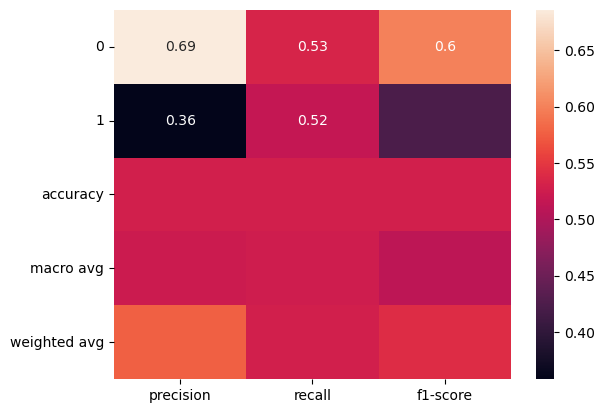

/Users/xerxes/anaconda3/envs/tensorflow/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/xerxes/anaconda3/envs/tensorflow/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/xerxes/anaconda3/envs/tensorflow/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set t

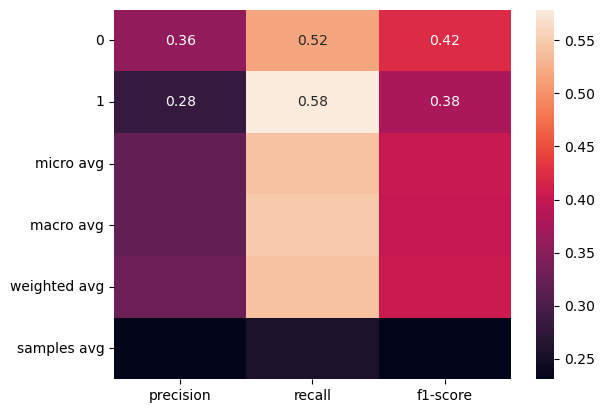

/Users/xerxes/anaconda3/envs/tensorflow/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/xerxes/anaconda3/envs/tensorflow/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/xerxes/anaconda3/envs/tensorflow/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set t

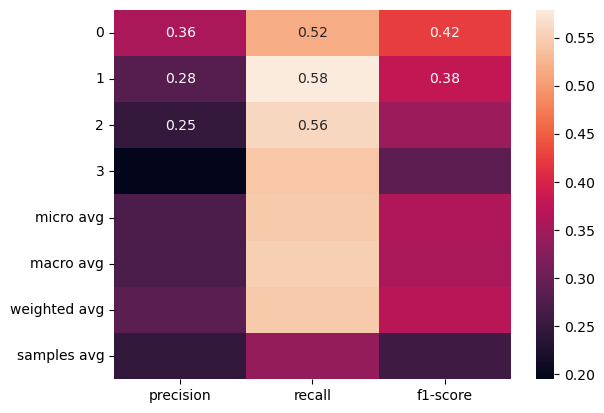

/Users/xerxes/anaconda3/envs/tensorflow/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/xerxes/anaconda3/envs/tensorflow/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/xerxes/anaconda3/envs/tensorflow/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set t

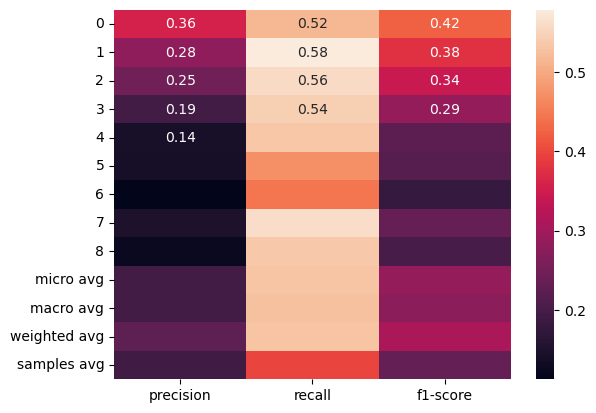

/Users/xerxes/anaconda3/envs/tensorflow/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/xerxes/anaconda3/envs/tensorflow/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/xerxes/anaconda3/envs/tensorflow/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set t

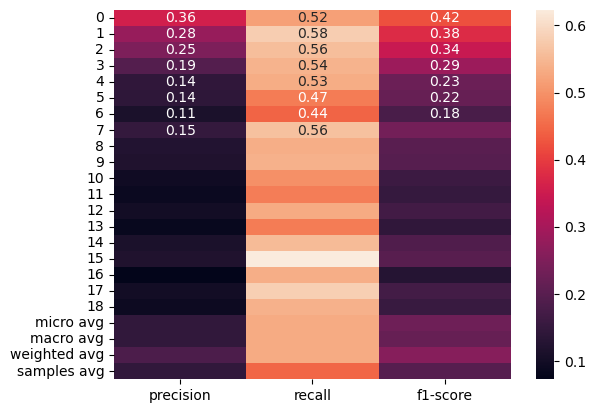

/Users/xerxes/anaconda3/envs/tensorflow/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/xerxes/anaconda3/envs/tensorflow/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/xerxes/anaconda3/envs/tensorflow/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set t

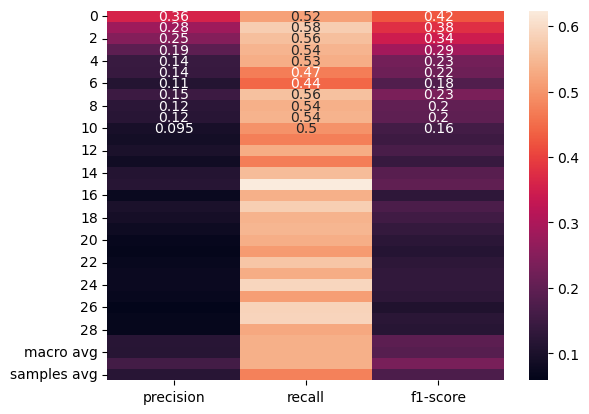

/Users/xerxes/anaconda3/envs/tensorflow/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/xerxes/anaconda3/envs/tensorflow/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/xerxes/anaconda3/envs/tensorflow/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set t

KeyboardInterrupt: 

In [11]:
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import seaborn as sns


with open('Top_N_Ingredients_Analysis_Output', 'a') as file:

    for num_ingredients in [2,3,5,10,20,30,50,100,200,400,500,1000]:

        top_rank_n = num_ingredients

        top_column_list = [row[0] for row in ranked_columns]

        top_column_list = top_column_list[0:top_rank_n]

        top_rank_allergies = [[row[col -1] for col in top_column_list] for row in allergiesArray]

        top_rank_allergies

        allergiesRanked = np.array(top_rank_allergies)

        allergiesRanked = allergiesRanked[:, 1:]

        X_train, X_test, y_train, y_test = train_test_split(input_data, allergiesRanked, test_size=0.2, random_state=42, shuffle=True)

        brf_classifier = MultiOutputClassifier(BalancedRandomForestClassifier(random_state=0, n_estimators=1000))

        brf_classifier.fit(X_train, y_train)

        svm_predictions = brf_classifier.predict(X_test)

        report = classification_report(y_test, svm_predictions,zero_division=0)

        file.write(report+'\n')


